In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso , LassoCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings 
warnings.filterwarnings('ignore')


# 1 

### Death rate

What is a good way to measure Covid death rate? There are quite a number of counties with a very low or none number of deaths. We have created a new measurement of death rate as follows:
- The total number of death for each county is gathered by November 1st, 2020
- The death rate is calculated as the total number of deaths plus 1 in the county divided by the total population of the county plus 2. We then apply the function log to get the
log death rate. 

$death rate = (deaths + 1) / (population + 2)$ then $y = log(death rate)$

In [7]:
covid_county = pd.read_csv("covid_county_midterm_real.csv")  

covid_county_sub = covid_county[['log_death_rate', 'State', 'Deep_Pov_All', 'PovertyAllAgesPct',
    'PerCapitaInc', 'UnempRate2019', 'PctEmpFIRE', 'PctEmpConstruction',
    'PctEmpTrans', 'PctEmpMining', 'PctEmpTrade', 'PctEmpInformation',
    'PctEmpAgriculture', 'PctEmpManufacturing', 'PctEmpServices',
    'PopDensity2010', 'OwnHomePct', 'Age65AndOlderPct2010',
    'TotalPop25Plus', 'Under18Pct2010', 'Ed2HSDiplomaOnlyPct',
    'Ed3SomeCollegePct', 'Ed4AssocDegreePct', 'Ed5CollegePlusPct',
    'ForeignBornPct', 'Net_International_Migration_Rate_2010_2019',
    'NetMigrationRate1019', 'NaturalChangeRate1019', 'TotalPopEst2019',
    'WhiteNonHispanicPct2010', 'NativeAmericanNonHispanicPct2010',
    'BlackNonHispanicPct2010', 'AsianNonHispanicPct2010', 'HispanicPct2010',
    'Type_2015_Update', 'RuralUrbanContinuumCode2013', 'UrbanInfluenceCode2013',
    'Perpov_1980_0711', 'HiCreativeClass2000', 'HiAmenity',
    'Retirement_Destination_2015_Update'
]]

## 2 EDA

During the course of pandemic, we have witnessed that many policies are carried out at state level. For example when to reopen after the March lock-down. To see the variability of death rates among
states we suggest you to go through the following EDA process.

Question 1: (3 parts)

1. Create the average log death rate by State. Show the histogram of the average log death rate
by State. Use no more than three sentences to summarize the variability of the average
log death rate by State.

There is noticeable variability considering state average log_death_rates. The distribution is slightly skewed, indicating higher mean log_death_rates in a small group of states and significantly lower averages in others. Most states cluster around the center of the distribution as indicated by the histogram. 

2. To see within State county level variability, make box-plots log death rate by State. Use
no more than two lines to describe the variability of log death rate by State.

Variability differs with-in states at the county level some high-mean states have wider interquartile ranges and long tails, indicating county differences that could be the result of demographics and policy. Other states have slimmer IQRs indicating more continuity and consistency of log_death_rate (less variance). 

3. What is the state with the highest average log death rate, and what is this rate?

New Jersey...with a mean log_death_rate of ~-6.467 

,State,mean_log_death_rate
0,AL,-7.266168
1,AR,-7.368115
2,AZ,-7.004942
3,CA,-8.349247
4,CO,-8.253809


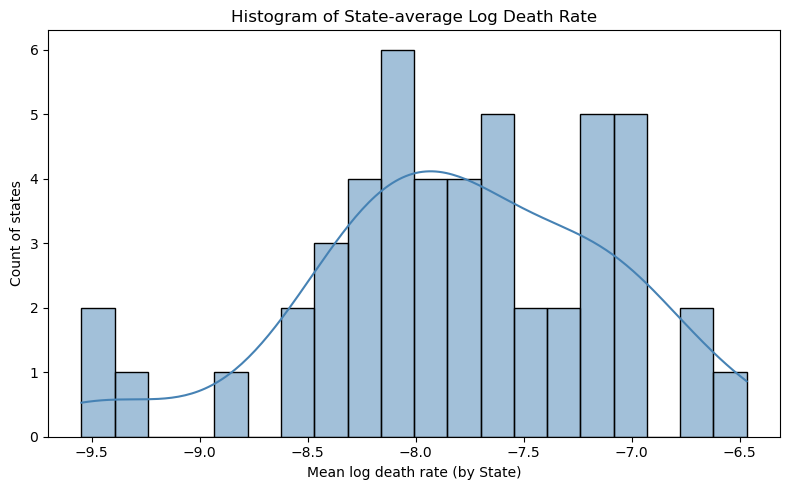

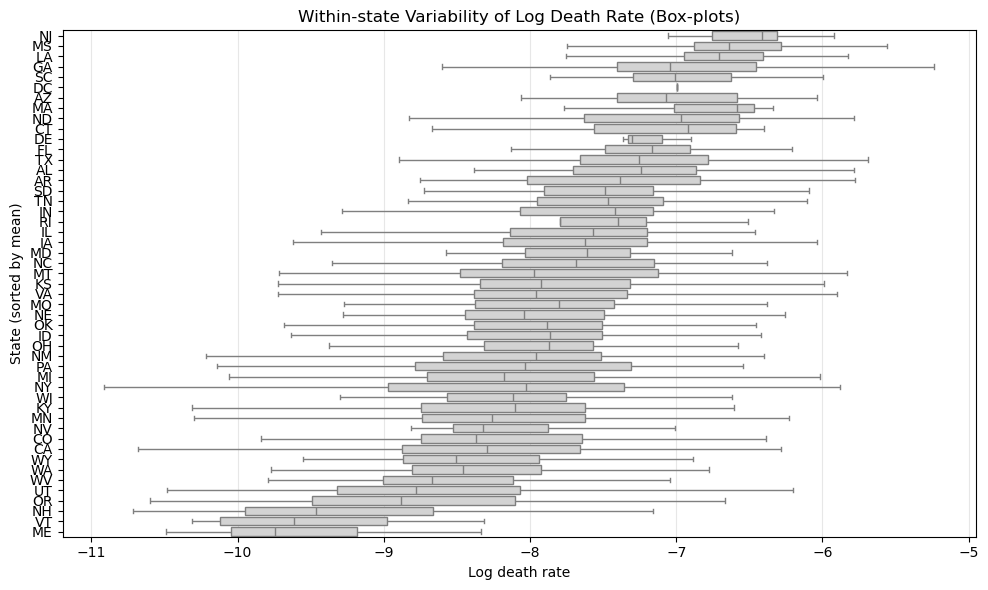

-6.467327636338059


In [26]:
mean_by_state = (
    covid_county_sub.groupby('State', as_index=False)['log_death_rate']
    .mean()
    .rename(columns={'log_death_rate': 'mean_log_death_rate'})
    .dropna()
)

display(mean_by_state.head())

order = mean_by_state.sort_values('mean_log_death_rate', ascending=False)['State']

plt.figure(figsize=(8,5))
sns.histplot(mean_by_state['mean_log_death_rate'], bins=20, kde=True, color='steelblue')
plt.title('Histogram of State-average Log Death Rate')
plt.xlabel('Mean log death rate (by State)')
plt.ylabel('Count of states')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=covid_county_sub,
    y='State', x='log_death_rate',
    order=order, showfliers=False, color='lightgray'
)
plt.title('Within-state Variability of Log Death Rate (Box-plots)')
plt.xlabel('Log death rate')
plt.ylabel('State (sorted by mean)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

top = mean_by_state.loc[mean_by_state['mean_log_death_rate'].idxmax()]
print(top['mean_log_death_rate'])


# 3 Analyses

In the following analyses, we try to find out factors related to log death rate.

#### 3.1 fit1: Age and log death rate

There are a number of studies indicating covid claimed most of elder lives. Let us start with a simple regression of log death rate vs. Age65AndOlderPct2010.

Question 2: (1 part)

1. Is Age65AndOlderPct2010 a significant variable at .01 level in this analysis? Show the p-value.

**Answer** According to the simple model, "Age65AndOlderPct2010" is not a significant variable at all as the p-value is 0.957, which is much larger than the cutoff at 0.01. 

#### 3.2 fit2: Age and log death rate controlling for State

Question 3: (5 parts)
How do Age65AndOlderPct2010 and State collectively affect log death rate. In fit2, run a linear model of log death rate vs State and Age65AndOlderPct2010 (without interactions).

1. Is Age65AndOlderPct2010 significant at .01 level in this model?

**Answer** Yes, it is 0.000212

2. How to interpret the coefficient of Age65AndOlderPct2010 over the log death rate in fit2?
How would you explain the difference in effects of Age65AndOlderPct2010 in fit1 vs fit2. (No
more than 3 sentences).

**Answer** Holding State fixed, a 1 percent increase in Age65AndOlderPct2010 changes the death rate by ≈ 1.35% e^(0.0134). Once you account for state, you can clearly see the within-state impacts of county and age 

3. Perform a test to see if State is significant in this model at .01 level?

4. Based on fit2, what is the estimated log death rate for a county in NJ and AL given Age65AndOlderPct2010 = 20 respectively. Note that the base level of State is AL. Show your formula and evaluate the final values. Do not use predict() in this question.

**answer** 

a)  NJ 

NJ = −6.3840 = −7.4691 + 0.0134·20 + 0.8171

b) AL

AL = −7.2011 = −7.4691 + 0.0134·20

5. Are the linear model assumptions reasonably met in fit2? Provide residual and normal plots
for fit2. Use no more than three sentences summarizing your model diagnoses.

**answer** Yes, generally speaking linearity and homoscedasticity are deemed valid looking at teh residual plots. No significant or noteworthy patterns or fanning. The q-q plot shows that the distribution is relatively normal and follows the 45 degree angle of the charted line, so normality assumption is validated. No interference can be further tested by plotting against specific observations to spot patterns.


In [22]:
# 3.1

cc_sub_age = covid_county_sub[['log_death_rate', 'Age65AndOlderPct2010']].dropna()

fit1 = ols('log_death_rate ~ Age65AndOlderPct2010', data=cc_sub_age).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_death_rate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.002940
Date:                Tue, 04 Nov 2025   Prob (F-statistic):              0.957
Time:                        12:01:23   Log-Likelihood:                -4012.0
No. Observations:                3016   AIC:                             8028.
Df Residuals:                    3014   BIC:                             8040.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -7.7103 

                            OLS Regression Results                            
Dep. Variable:         log_death_rate   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     32.51
Date:                Tue, 04 Nov 2025   Prob (F-statistic):          8.10e-237
Time:                        12:17:46   Log-Likelihood:                -3363.7
No. Observations:                3016   AIC:                             6827.
Df Residuals:                    2966   BIC:                             7128.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -7.4691 

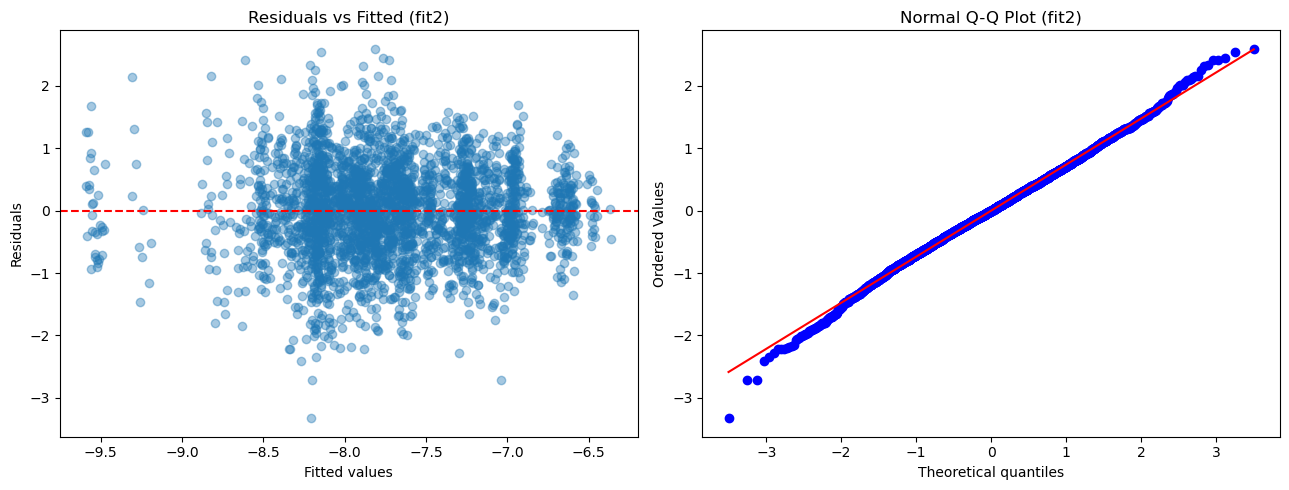

In [32]:
# 3.2 

multi = covid_county_sub[['log_death_rate','State','Age65AndOlderPct2010']].dropna().copy()

# AL is the reference cause its first 
formula = 'log_death_rate ~ C(State) + Age65AndOlderPct2010'
fit2 = ols(formula, data=multi).fit()
print(fit2.summary())

# 1) finding teh pvalue
age_pval = fit2.pvalues.get('Age65AndOlderPct2010', float('nan'))
print(age_pval) 

# 3) state block test model without State vs with State 
fit_restricted = ols('log_death_rate ~ Age65AndOlderPct2010', data=multi).fit()
anova_tbl = anova_lm(fit_restricted, fit2)
print(anova_lm(fit_restricted, fit2))


# 5) resid and qq
resid = fit2.resid
fitted = fit2.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].scatter(fitted, resid, alpha=0.4)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted (fit2)')

stats.probplot(resid, dist='norm', plot=axes[1])
axes[1].set_title('Normal Q-Q Plot (fit2)')

plt.tight_layout()
plt.show()

#### 3.3 

In this section, using all possible variables available in covid county sub, we will build a final parsi-
monious model and to identify a set of important variables that are related to the log death rate.
We will not fine-tune the final model.

As you have seen State effect explains a large portion of variability in log death rate, we will
lock State in all the analyses

In [55]:
# 3.3 Final model


df = covid_county_sub.copy()
y_col = 'log_death_rate'
state_col = 'State'

num_cols = df.select_dtypes(include=[np.number]).columns.drop(y_col, errors='ignore')

use_cols = [y_col, state_col] + list(num_cols)
df_model = df[use_cols].dropna().copy()


if len(num_cols) > 0:
    rhs = ' + '.join(num_cols)
    formula_all = f'{y_col} ~ C({state_col}) + ' + rhs
else:
    formula_all = f'{y_col} ~ C({state_col})'


fit_final_all = sm.formula.ols(formula_all, data=df_model).fit()
print(fit_final_all.summary())


                            OLS Regression Results                            
Dep. Variable:         log_death_rate   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     30.46
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:50:54   Log-Likelihood:                -3040.1
No. Observations:                3016   AIC:                             6256.
Df Residuals:                    2928   BIC:                             6785.
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

#### 4

Important Remark: You are going to run LASSO to pick up a few variables in addition to the
State. In case you can’t get LASSO to work go to 2) directly and use the following set of variables
to get your fit.final: State, PctEmpServices, PopDensity2010, Age65AndOlderPct2010, WhiteNon-
HispanicPct2010, HiCreativeClass2000. (Note: this is not necessarily the LASSO output.)


1. Use LASSO to pick up a few variables in addition to State. List variables output from the
above LASSO. To be specific let us control the following settings to get the same results.

Use random state=1 to control the cross-validation errors.
Use 10-fold cross validations.
Force State in all the LASSO models.
Pick up the final set of variables using lambda corresponding to 1 standard error rule
(alpha 1se)

2. Run a final model fit.final of log death rate vs State and the set of variables obtained
from your LASSO output. Also include Age65AndOlderPct2010 regardless whether it is
in your LASSO output or not. (You can easily specify the model variables without any
algorithm.) Report the summary of fit.final.


3. Is State significant at .01 level in this model? Is Age65AndOlderPct2010 significant at .01
level in this model?

**answer**  State: highly significant block F-test p = 5.43e-177.

Age65AndOlderPct2010: significant 1.25e-14  with a psoitive coefficient ~0.0316.


4. Controlling for all other variables in fit.final, which state has the highest log death rate
and what is the value?

**answer** Controlling for all variablestop state is remains NJ with a log_death_rate of -6.7847.

5. Assume all linear model assumptions are met. Write a brief summary of your findings based
on fit.final. (No more than 4 lines after compiled)

**answer** -> 

- Final OLS explains R^2=0.475 with State effects significant at 0.01 (p=3.80e-103). 

- Age65AndOlderPct2010 is significant at 0.01 (beta=0.0425, p=1.01e-08), indicating within-state age relates to mortality. This is not necessarily causal, but associated

 - LASSO (1SE) selected 38 additional numeric predictors: 

 - Controlling for all variables, NJ has the highest expected log death rate at -6.7847.

In [ ]:
# 4 — LASSO selection (State locked) + Final OLS

_df = covid_county_sub.copy()
y_col = 'log_death_rate'
state_col = 'State'

# keep only rows with complete data across y, state, and numeric predictors
num_cols_all = _df.select_dtypes(include=[np.number]).columns.drop(y_col, errors='ignore')
use_cols = [y_col, state_col] + list(num_cols_all)
df_full = _df[use_cols].dropna().copy()

# 1) locking state
state_dummies = pd.get_dummies(df_full[state_col], drop_first=True)

y = df_full[y_col].astype(float).values
X_state = sm.add_constant(state_dummies.astype(float), has_constant='add').values
fit_y_on_state = sm.OLS(y, X_state).fit()
y_resid = fit_y_on_state.resid


X_num = df_full[num_cols_all].astype(float)
X_resid = pd.DataFrame(index=df_full.index)
for col in num_cols_all:
    xi = X_num[col].values
    fit_x_on_state = sm.OLS(xi, X_state).fit()
    X_resid[col] = fit_x_on_state.resid

# standardize predictors before 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resid.values)

lasso_cv = LassoCV(cv=10, random_state=1, fit_intercept=False, n_alphas=100, max_iter=10000)
lasso_cv.fit(X_scaled, y_resid)

# just copied midterm notes...
mse_path = lasso_cv.mse_path_ 
mean_mse = mse_path.mean(axis=1)
se_mse = mse_path.std(axis=1, ddof=1) / np.sqrt(mse_path.shape[1])
min_idx = int(np.argmin(mean_mse))
alpha_min = float(lasso_cv.alphas_[min_idx])
threshold = mean_mse[min_idx] + se_mse[min_idx]
eligible = np.where(mean_mse <= threshold)[0]
if eligible.size:
    eligible_alphas = lasso_cv.alphas_[eligible]
    alpha_1se = float(eligible_alphas.max())
else:
    alpha_1se = alpha_min

# lasso at 1se
lasso_1se = Lasso(alpha=alpha_1se, fit_intercept=False, max_iter=10000)
lasso_1se.fit(X_scaled, y_resid)

coef = lasso_1se.coef_
selected_vars = [num_cols_all[i] for i, c in enumerate(coef) if abs(c) > 1e-8]

print('LASSO selection complete:')
print(f"  alpha_min = {alpha_min:.6g}")
print(f"  alpha_1se = {alpha_1se:.6g}")
print(f"  Selected variables (in addition to State):\n    {selected_vars if selected_vars else 'None'}")


forced_age = 'Age65AndOlderPct2010'
final_vars = list(sorted(set(selected_vars) | {forced_age}))

used_cols_final = [y_col, state_col] + final_vars
df_final = df_full[used_cols_final].dropna().copy()

rhs = 'C(' + state_col + ')'
if len(final_vars) > 0:
    rhs += ' + ' + ' + '.join(final_vars)
formula_final = f"{y_col} ~ {rhs}"

fit_final = ols(formula_final, data=df_final).fit()
print(fit_final.summary())


if len(final_vars) > 0:
    formula_no_state = f"{y_col} ~ " + ' + '.join(final_vars)
else:
    formula_no_state = f"{y_col} ~ 1"
fit_no_state = ols(formula_no_state, data=df_final).fit()

anova_tbl = anova_lm(fit_no_state, fit_final)
state_pval = float(anova_tbl['Pr(>F)'].iloc[-1])

age_pval = float(fit_final.pvalues.get(forced_age, np.nan))
age_coef = float(fit_final.params.get(forced_age, np.nan))


print(anova_tbl)

# Which state has the highest log death rate holding everything else constant
uniq_states = sorted(df_final[state_col].unique())
rows = []
for s in uniq_states:
    row = {state_col: s}
    for v in final_vars:
        row[v] = df_final[v].mean()
    rows.append(row)
pred_df = pd.DataFrame(rows)
preds = fit_final.predict(pred_df)
max_idx = int(np.argmax(preds.values))
high_state = pred_df[state_col].iloc[max_idx]
high_value = float(preds.iloc[max_idx])

print(f"\nTop state (controlling for all variables at their means): {high_state} = {high_value:.4f}")



LASSO selection complete:
  alpha_min = 0.00164743
  alpha_1se = 0.0764668
  Selected variables (in addition to State):
    ['PctEmpAgriculture', 'Age65AndOlderPct2010', 'Ed5CollegePlusPct', 'NetMigrationRate1019', 'WhiteNonHispanicPct2010']
                            OLS Regression Results                            
Dep. Variable:         log_death_rate   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     44.85
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:47:35   Log-Likelihood:                -3123.5
No. Observations:                3016   AIC:                             6355.
Df Residuals:                    2962   BIC:                             6680.
Df Model:                          53                                         
Covariance Type:            nonrobust          